# Итоговая работа по соревнованию [SF] Car classification Классифицируем автомобиль по картинке
Выполнил Евгений Мурзагильдинов, гр.DST-41

In [10]:
# проверяем, что видеокарта подключена
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-79006a2c-c0a8-5d9e-c31c-05dc2ae06da9)


In [11]:
# подготавливаем данные

# для Google Colab:
!gsutil cp gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip .
!unzip sf-dl-car-classification.zip
!unzip -q -o sf-dl-car-classification/train.zip
!unzip -q -o sf-dl-car-classification/test.zip
sample_submission_path = '/content/sf-dl-car-classification/sample-submission.csv'y
train_path = '/content/train/'
sub_path = '/content/test_upload/'

#имена классов
class_names = [
  'Приора', #0
  'Ford Focus', #1
  'Самара', #2
  'ВАЗ-2110', #3
  'Жигули', #4
  'Нива', #5
  'Калина', #6
  'ВАЗ-2109', #7
  'Volkswagen Passat', #8
  'ВАЗ-21099' #9
]

Copying gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip...
| [1 files][  1.6 GiB/  1.6 GiB]   39.6 MiB/s                                   
Operation completed over 1 objects/1.6 GiB.                                      
Archive:  sf-dl-car-classification.zip
replace sf-dl-car-classification/sample-submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sf-dl-car-classification/sample-submission.csv  
replace sf-dl-car-classification/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sf-dl-car-classification/train.csv  
replace sf-dl-car-classification/test.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: sf-dl-car-classification/test.zip  y

replace sf-dl-car-classification/train.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename:  extracting: sf-dl-car-classification/train.zip  y



In [9]:
# импорты

import os, re, math, random, time, gc, string, pickle, shutil, pathlib, itertools
import numpy as np, pandas as pd, matplotlib.pyplot as plt, PIL

import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm

**Как будем делить данные?**

Мы имеем обучающий датасет и датасет для сабмита (тестовый). Количество сабмитов ограничено 5 в сутки, поэтому перед сабмитом нужно как-то оценить модель, чтобы следить за переобучением и не сабмитить заранее проигрышные решения. Для этого от обучающего датасета мы отделяем валидационный.

Мы можем поделить данные например в таком соотношении:

*   **train** - 80% обучающих изображений
*   **val** (валидационный датасет) - 20% обучающих изображений
*   **sub** (submission) - тестовые изображения для сабмита, к которым не дано ответов

**Создаем генераторы изображений**

In [12]:
image_size = (90, 120)
batch_size = 32

train_datagen = ImageDataGenerator(
    #rescale=1/255,
    validation_split=0.2,
    # ниже параметры аугментаций:
    horizontal_flip=True,
    rotation_range=10,
    shear_range=0.2,
    brightness_range=(0.8, 1.2),
)

val_datagen = ImageDataGenerator(
    #rescale=1/255,
    validation_split=0.2,
)

sub_datagen = ImageDataGenerator(
    #rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='validation'
)

sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


Train:


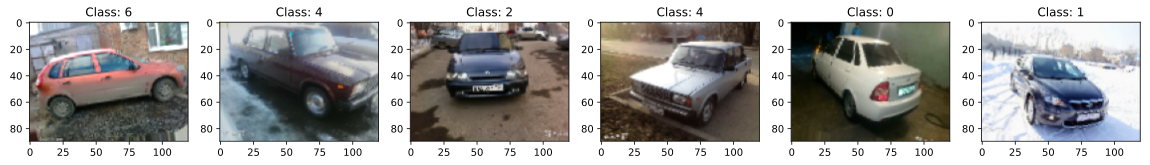

Val:


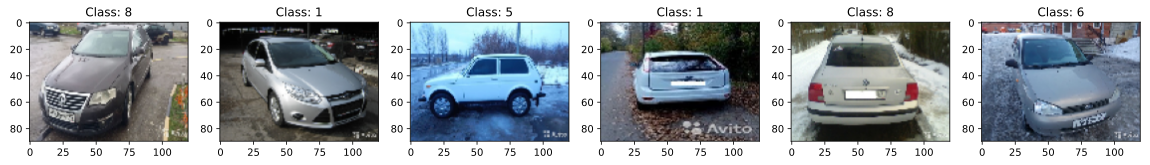

Sub:


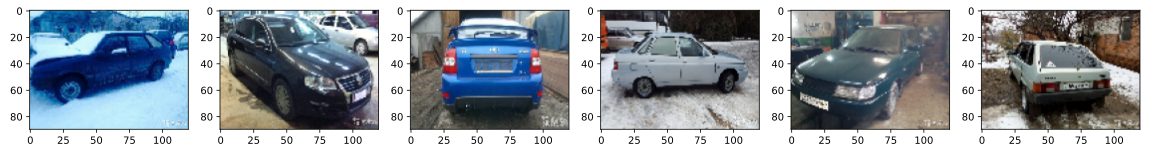

In [13]:
def show_first_images(generator, count=6, labels=True, figsize=(20, 5), normalized=False):
  generator = itertools.islice(generator, count)
  fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
  for batch, ax in zip(generator, axes):
    if labels:
      img_batch, labels_batch = batch
      img, label = img_batch[0], np.argmax(labels_batch[0]) #берем по одному изображению из каждого батча
    else:
      img_batch = batch
      img = img_batch[0]
    if not normalized:
      img = img.astype(np.uint8)
    ax.imshow(img)
    # метод imshow принимает одно из двух:
    # - изображение в формате uint8, яркость от 0 до 255
    # - изображение в формате float, яркость от 0 до 1
    if labels:
      ax.set_title(f'Class: {label}')
  plt.show()

print('Train:')
show_first_images(train_generator)

print('Val:')
show_first_images(val_generator)

print('Sub:')
show_first_images(sub_generator, labels=False)

In [16]:
# строим модель
base_model = Sequential([
  EfficientNetB6(weights='imagenet', input_shape=(*image_size, 3), include_top=False)]) #предобученная нейросеть из модуля keras.applications 

165249024/165234480 [==============================] - 2s 0us/step


In [17]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 3, 4, 2304)        40960143  
Total params: 40,960,143
Trainable params: 40,735,704
Non-trainable params: 224,439
_________________________________________________________________


In [20]:
# достраиваем модель на основе базовой
model=Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, 
                      activation='relu', 
                      bias_regularizer=l2(1e-4),
                      activity_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(CLASS_NUM, activation='softmax'))

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 3, 4, 2304)        40960143  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,817
Trainable params: 41,328,866
Non-trainable params: 224,951
____________________________________

**Model fit**

In [23]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(learning_rate=LR), 
              metrics=["accuracy"])

In [24]:
# добавим чекпойнты для сохранения лучшей версии и ещё немного фичей
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor = ['val_accuracy'], 
                             verbose = 1,
                             mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 4,
                          restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [26]:
history = model.fit(train_generator, validation_data=val_generator, epochs=10,
        callbacks = callbacks_list)

Epoch 1/10
390/390 [==============================] - 374s 794ms/step - loss: 1.8803 - accuracy: 0.3965 - val_loss: 1.9004 - val_accuracy: 0.3258

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
390/390 [==============================] - 303s 777ms/step - loss: 1.3258 - accuracy: 0.5498 - val_loss: 0.8038 - val_accuracy: 0.7083

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
390/390 [==============================] - 303s 777ms/step - loss: 0.8000 - accuracy: 0.7249 - val_loss: 0.6159 - val_accuracy: 0.7787

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
390/390 [==============================] - 303s 776ms/step - loss: 0.6341 - accuracy: 0.7806 - val_loss: 0.6685 - val_accuracy: 0.7999

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
390/390 [==============================] - 303s 776ms/step - loss: 0.4942 - accuracy: 0.8330 - val_loss: 0.6840 - val_accuracy: 0.7871

Epoch 00005: saving model to best_model.hdf5

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6/10
390/390 [==============================] - 303s 776ms/step - loss: 0.3123 - accuracy: 0.8932 - val_loss: 0.3238 - val_accuracy: 0.8823

Epoc

**Неплохо для первого раза!**

In [27]:
#model.save('../working/model_last.hdf5') 
model.load_weights('best_model.hdf5')

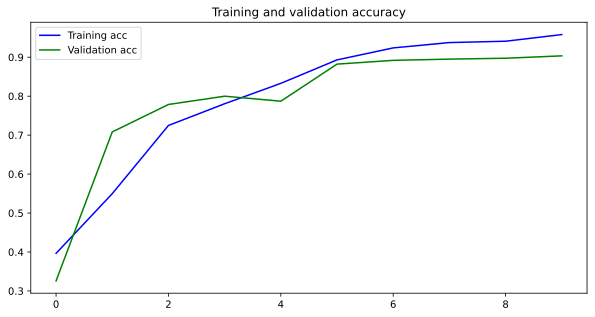

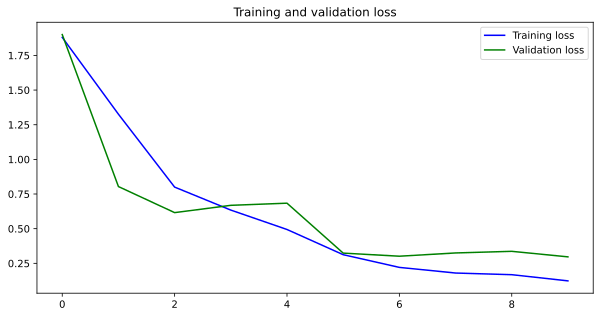

In [29]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy'] 
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

**Обучение шло неплохо, думаю даже если просто добавить количество эпох и не менять модель то можно получить точность 0,97-0,98**

Сделаем файл для сабмита:

In [30]:
predictions = model.predict(sub_generator, verbose=1)
predictions = predictions.argmax(axis=1)

submission = pd.DataFrame({
    'Id': sub_generator.filenames,
    'Category': predictions
}, columns=['Id', 'Category'])
submission.to_csv('submission.csv', index=False)

209/209 [==============================] - 50s 218ms/step


# Правила сдачи работы

Работа сдается через платформу [lms.skillfactory.ru](https://lms.skillfactory.ru) на странице проекта Ford vs Ferrari.

**Вариант 1.** Ссылка на ноутбук на Kaggle. Если ваш ноутбук приватный, то **откройте к нему доступ** для [проверяющего ментора](https://www.kaggle.com/olegzyablov).

**Вариант 2.** Ссылка на Google Colab или другой ресурс, с которого можно скачать ноутбук с кодом. Не забудьте проверить, что ссылка работает и к ноутбуку **открыт доступ**. Также **укажите ваш никнейм на Kaggle**, чтобы можно было найти вас в лидерборде.

По желанию укажите предпочитаемый способ связи с вами (Slack, Telegram, ...).